In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# load data
df = pd.read_csv("churn_dataset.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
#cleaning
df = df.copy()
#dropping customer_id coz useless
if "customerID" in df.columns:
    df = df.drop("customerID", axis=1)
#convert Yes/No columns automatically to numerical values
yes_no_cols = [ col for col in df.columns
               if df[col].dtype == 'object' and df[col].isin(["Yes","No"]).any()]
for col in yes_no_cols:
    df[col] = df[col].map({"Yes":1,"No":0})
#convert numeric like strings
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')
#handlw missinf values
df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])

df.head

/var/folders/0p/qj957hq50gb6rh1qs3d2wxj40000gn/T/ipykernel_47458/276975154.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


<bound method NDFrame.head of       gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0     Female              0        1           0       1             0   
1       Male              0        0           0      34             1   
2       Male              0        0           0       2             1   
3       Male              0        0           0      45             0   
4     Female              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038    Male              0        1           1      24             1   
7039  Female              0        1           1      72             1   
7040  Female              0        1           1      11             0   
7041    Male              1        1           0       4             1   
7042    Male              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0          

In [6]:
#t-t-s
X = df.drop("Churn", axis = 1)
y =df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
#encoding(ohe) + scaling
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(
    transformers= [
        ('num', StandardScaler(), numeric_features),
        ('cat',OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [10]:
#training (RF)
model = Pipeline(
    steps=[
        ('preprocess',preprocess),
        ('clf',RandomForestClassifier(
            n_estimators=200,
            random_state=42
        ))
    ]
)
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
#evaluation
pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test,pred))
print("\nClassification Report:\n")
print(classification_report(y_test,pred))

Accuracy: 0.7877927608232789

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.64      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.77      1409



In [12]:
#graph rep
ohe = model.named_steps['preprocess'].named_transformers_['cat']
cat_names = list(ohe.get_feature_names_out(categorical_features))

feature_names = list(numeric_features) + cat_names

importances = model.named_steps['clf'].feature_importances_

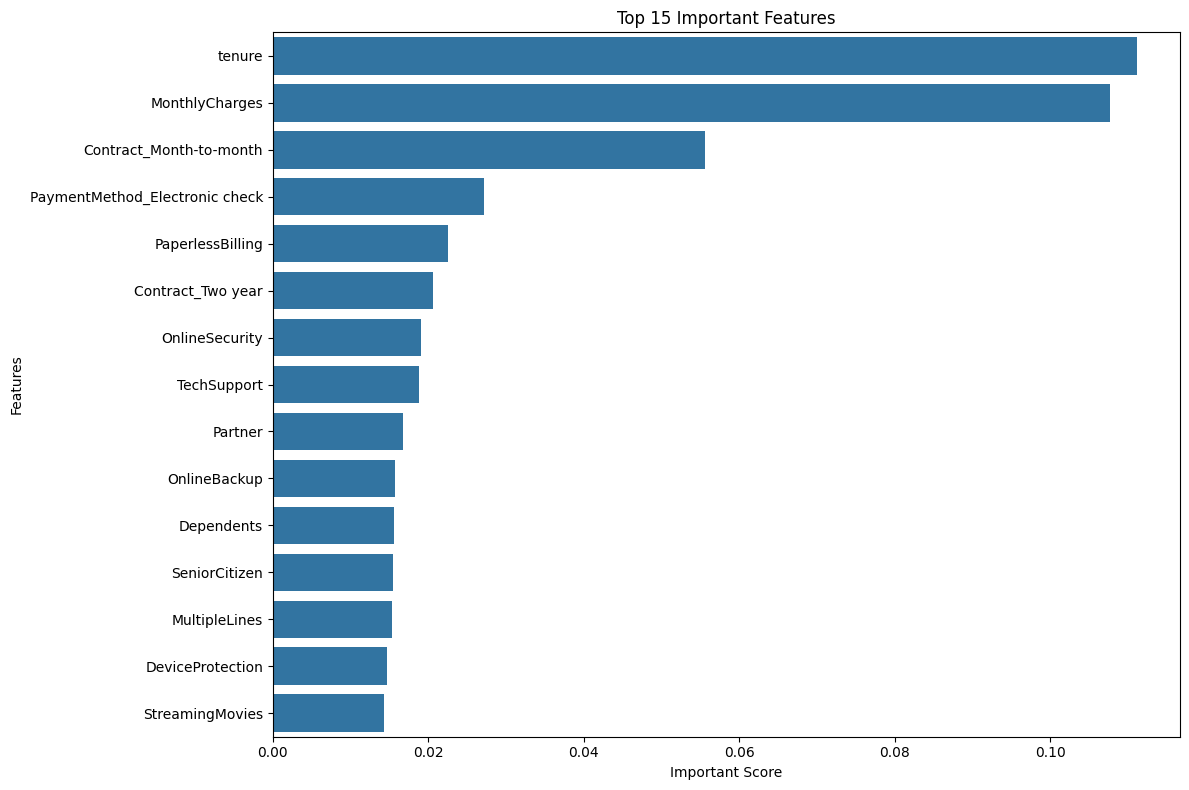

In [14]:
#plot of top 15 important df for visualization 
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})
#sort and show top 15
fi = fi.sort_values("importance", ascending=False).head(15)

#plot
plt.figure(figsize=(12,8))
sns.barplot(x="importance", y="feature", data=fi)
plt.title("Top 15 Important Features")
plt.xlabel("Important Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [15]:
#model single customer
sample = X.iloc[0:1]
model.predict(sample)

array([0])

In [16]:
#save model in joblib
joblib.dump(model,"churn_model.pkl")

['churn_model.pkl']